# Generate Simulation data from NASA planet database

This is an optional notebook that generates simulated orbits for planets from the NASA database (and a few extra ones "by hand" too!).

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# extra
from glob import glob

A few extra things we'll need in external libraries:

In [73]:
from convert_kepler_data import convert_kepler_data
from hermite_library import do_hermite, save_hermite_solution_to_file, read_hermite_solution_from_file

Read in database file:

In [41]:
#planets = pd.read_csv('https://jnaiman.github.io/csci-p-14110_su2020/lesson08/planets_2020.06.17_14.04.11.csv', 
#                     sep=",", comment="#")

planets = pd.read_csv('planets_2020.06.22_10.10.17.csv',sep=",", comment="#")

In [42]:
planets.head()

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
0,1,11 Com,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1,2,11 UMi,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,3,14 And,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
3,4,14 Her,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,...,0.537,0.001,0.0,0.366,0.002,0.0,0.438,0.006,0.0,9.0
4,5,16 Cyg B,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,...,0.418,0.003,0.0,0.222,0.003,0.0,0.351,0.003,0.0,17.0


In [43]:
len(planets)

4164

Now we choose systems to simulate.  I'm gonna pick all systems with > 4 planets:

In [96]:
mask = planets['pl_pnum'] > 4

Subset dataframe:

In [97]:
multi_planets = planets[mask]

In [98]:
multi_planets

,rowid,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
25,26,55 Cnc,b,55 Cnc b,Radial Velocity,0,5,14.651520,0.000150,-0.000150,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
26,27,55 Cnc,c,55 Cnc c,Radial Velocity,0,5,44.417500,0.007300,-0.007300,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
27,28,55 Cnc,d,55 Cnc d,Radial Velocity,0,5,4825.000000,39.000000,-39.000000,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
28,29,55 Cnc,e,55 Cnc e,Radial Velocity,0,5,0.736539,0.000007,-0.000007,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
29,30,55 Cnc,f,55 Cnc f,Radial Velocity,0,5,262.000000,0.510000,-0.510000,...,0.536,0.002,0.0,0.357,0.004,0.0,0.415,0.005,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,3908,TRAPPIST-1,d,TRAPPIST-1 d,Transit,0,7,4.049610,0.000063,-0.000063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3908,3909,TRAPPIST-1,e,TRAPPIST-1 e,Transit,0,7,6.099615,0.000011,-0.000011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3909,3910,TRAPPIST-1,f,TRAPPIST-1 f,Transit,0,7,9.206690,0.000015,-0.000015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3910,3911,TRAPPIST-1,g,TRAPPIST-1 g,Transit,0,7,12.352940,0.000120,-0.000120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


Make new dataframe that only includes dynamical elements of interest *for each system*:

In [99]:
names = np.unique(multi_planets['pl_hostname'].values)
names

array(['55 Cnc', 'GJ 667 C', 'HD 10180', 'HD 158259', 'HD 219134',
       'HD 34445', 'HD 40307', 'HIP 41378', 'K2-138', 'KOI-351',
       'Kepler-102', 'Kepler-11', 'Kepler-122', 'Kepler-150',
       'Kepler-154', 'Kepler-169', 'Kepler-186', 'Kepler-20',
       'Kepler-238', 'Kepler-292', 'Kepler-296', 'Kepler-32', 'Kepler-33',
       'Kepler-444', 'Kepler-55', 'Kepler-62', 'Kepler-80', 'Kepler-82',
       'Kepler-84', 'TRAPPIST-1'], dtype=object)

In [ ]:
savedNames = []
savedSims = []

for iname,name in enumerate(names): # for each planetary system
    print('On ' + name + ' - ' + str(iname+1) + ' of ' + str(len(names)) + ' systems')
    # only select entries with this name
    mask = multi_planets['pl_hostname'] == name
    ecc = multi_planets['pl_orbeccen'][mask]
    a = multi_planets['pl_orbsmax'][mask]
    Porb = multi_planets['pl_orbper'][mask]
    Incl = multi_planets['pl_orbincl'][mask]
    sMass = multi_planets['st_mass'][mask]
    pMass = multi_planets['pl_bmassj'][mask]
    tTime = multi_planets['pl_orbtper'][mask]

    # if no incl, set to zero
    Incl[np.isnan(Incl)] = 0.0
    
    # if no tTime set to zero
    tTime[np.isnan(tTime)] = 0.0

    ecc[np.isnan(ecc)] = 0.0

    # now convert to kepler data dictionary
    # only entries we really need to use in the convert_kepler_data function
    kepler_data = {}

    mask2 = np.isnan(pMass) # check for actual masses stored
    kepler_data['SysName'] = name
    kepler_data['NumberOfPlanets'] = len(a) 
    kepler_data['Porb'] = Porb.values[~mask2]
    kepler_data['a']=a.values[~mask2]
    kepler_data['ecc']=ecc.values[~mask2]
    kepler_data['Incl']=Incl.values[~mask2]
    kepler_data['pMass']=pMass.values[~mask2]
    kepler_data['sMass']=sMass.values[~mask2]
    kepler_data['tTime']=tTime.values[~mask2]
    
    #print(len(kepler_data['pMass']))

    # calculate inputs for sims
    if len(kepler_data['pMass']) > 0:
        star_mass, \
        planet_masses, \
        planet_initial_position, \
        planet_initial_velocity, ecc = convert_kepler_data(kepler_data)
        
        # do the sim!
        # uses a hermite solution
        r_h, v_h, t_h, e_h = do_hermite(star_mass, 
                                planet_masses, 
                                planet_initial_position, 
                                planet_initial_velocity, 
                               tfinal=1e7, Nsteps=8800)
        
        # save
        #savedNames.append(name)
        #savedSims.append( (r_h, v_h, t_h, e_h) )
        saveName = "_".join(name.split()) + '-savedSim.txt'
        
        # you can save it to your local directory, or another place
        save_hermite_solution_to_file('data/' + saveName, 
                                  t_h, e_h, r_h, v_h)
        print('   saved: data/' + saveName)
    else:
        print('   NO masses -- nothing saved for ' + name)

On 55 Cnc - 1 of 30 systems
   saved: data/55_Cnc-savedSim.txt
On GJ 667 C - 2 of 30 systems
   saved: data/GJ_667_C-savedSim.txt
On HD 10180 - 3 of 30 systems
   saved: data/HD_10180-savedSim.txt
On HD 158259 - 4 of 30 systems
   saved: data/HD_158259-savedSim.txt
On HD 219134 - 5 of 30 systems
   saved: data/HD_219134-savedSim.txt
On HD 34445 - 6 of 30 systems
   saved: data/HD_34445-savedSim.txt
On HD 40307 - 7 of 30 systems
   saved: data/HD_40307-savedSim.txt
On HIP 41378 - 8 of 30 systems
NO masses -- nothing saved for HIP 41378
On K2-138 - 9 of 30 systems
NO masses -- nothing saved for K2-138
On KOI-351 - 10 of 30 systems
NO masses -- nothing saved for KOI-351
On Kepler-102 - 11 of 30 systems
   saved: data/Kepler-102-savedSim.txt
On Kepler-11 - 12 of 30 systems


Groovy.  Now we can read in some of this data and plot it if we wanna:

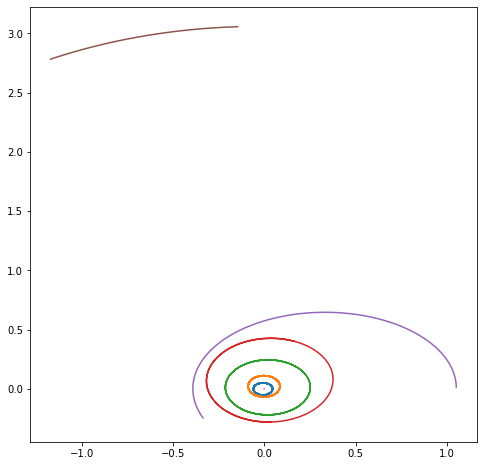

In [75]:
read_in_name = 'HD 10180'

fname = saveName = "_".join(read_in_name.split()) + '-savedSim.txt'
t_h, E_h, r_h, v_h = read_hermite_solution_from_file('data/' + fname)

# plot the sim
fig, ax = plt.subplots(1,1, figsize=(8,8))

# loop over the number of particles in our system (star + planets)
for i in range(r_h.shape[0]):
    # on the 0th i.e. first set of axis plot
    # the ith planet
    # the 0th (x) axis vs the 1st (y) axis
    # and plot all the time steps (:)
    ax.plot(r_h[i,0,:], r_h[i, 1, :])
    

plt.show()

Or, do all the orbits:

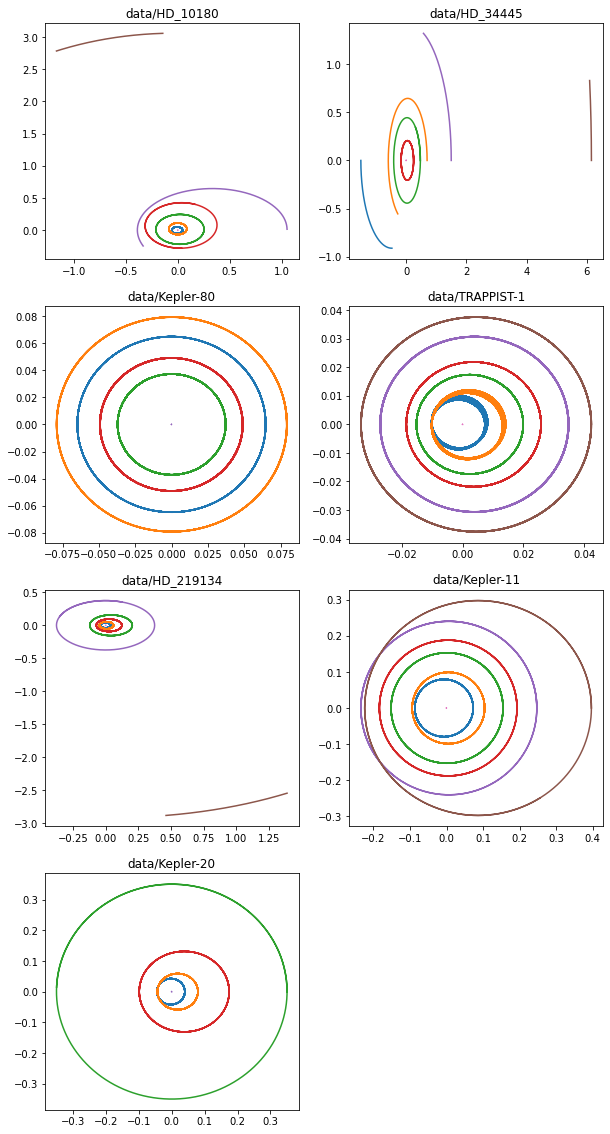

In [95]:
nx = 2
ny = 4

# for 1x1
baseWidth = 5
baseHeight = 5

fig, ax = plt.subplots(nrows=ny, ncols=nx, figsize = (baseWidth*nx, baseHeight*ny))
# flatten for easier manipulation
ax = ax.flatten()

ffiles = glob('data/*txt')

for j in range(len(ax)):
    if j < len(ffiles):
        t_h, E_h, r_h, v_h = read_hermite_solution_from_file(ffiles[j])

        # loop over the number of particles in our system (star + planets)
        for i in range(r_h.shape[0]):
            ax[j].plot(r_h[i,0,:], r_h[i, 1, :])
            
        # title
        title = ffiles[j].split('-savedSim')[0]
        ax[j].set_title(title)
    else: # else, turn off all axis
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        # for minor ticks
        ax[j].set_xticks([], minor=True)
        ax[j].set_yticks([], minor=True)
        # axlis lines
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].spines['bottom'].set_visible(False)
        
plt.show()